# Create instances of Data from log-normal mocks

In [1]:
import time

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction
from mockfactory import EulerianLinearMock, LagrangianLinearMock, RandomBoxCatalog, setup_logging
from iminuit import Minuit

import catalog_data
import density_split

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = density_split.DensitySplit.load(output_dir+catalog_name+'_density_split.npy')

## Mock properties

In [4]:
nmesh = 100
boxsize = catalog.boxsize
boxcenter = catalog.boxcenter
seed = 42
los = 'x'
nbar = catalog.data.size/catalog.boxsize**3

z = catalog.data.redshift

# Abacus summit cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

f = bg.growth_rate(z)
bias = 2.5

pklin = cosmo_abacus.get_fourier().pk_interpolator().to_1d(z)

## Abacus summit cosmology

In [5]:
# unitary_amplitude forces amplitude to 1
mock = LagrangianLinearMock(pklin, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=True)

# this is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias - 1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
#mock.set_rsd(f=f, los=los)
data = mock.to_catalog()

In [6]:
# Create Data instance
positions = data['Position'].T % boxsize

mock_catalog = catalog_data.Data(positions, z, boxsize, boxcenter, name='mock')
mock_catalog.save(data_dir+mock_catalog.name)

## Compute density

In [7]:
cellsize = 20
resampler = 'tsc'

# Compute density without weights
mock_density = density_split.DensitySplit(mock_catalog)
mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=False)

### Plot density distribution

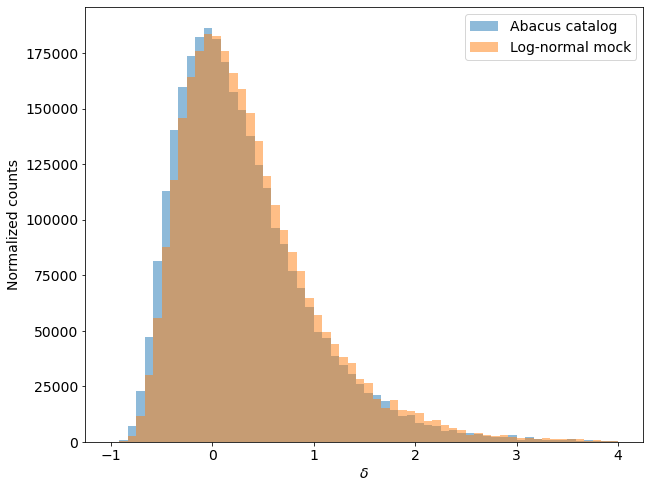

In [8]:
plt.hist(catalog.data_densities, range=(-1, 4), bins=60, density=False, alpha=0.5, label='Abacus catalog')
plt.hist(mock_density.data_densities, range=(-1, 4), bins=60, density=False, alpha=0.5, label='Log-normal mock')
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.legend()
plt.show()

## Fit bias on original catalog

In [9]:
# unitary_amplitude forces amplitude to 1
mock = LagrangianLinearMock(pklin, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=False)

In [14]:
def density_from_bias(b, data_catalog = catalog, nbins = 60, seed = 43, los = 'x'):
    boxsize = catalog.boxsize
    boxcenter = catalog.boxcenter
    nbar = catalog.data.size/catalog.boxsize**3

    z = catalog.data.redshift
    f = bg.growth_rate(z)
    
    bias = b

    # this is Lagrangian bias, Eulerian bias - 1
    mock.set_real_delta_field(bias=bias - 1)
    mock.set_analytic_selection_function(nbar=nbar)
    mock.poisson_sample(seed=seed)
    #mock.set_rsd(f=f, los=los)
    data = mock.to_catalog()
    
    # Create Data instance
    positions = data['Position'].T % boxsize

    mock_catalog = catalog_data.Data(positions, z, boxsize, boxcenter, name='mock')
    mock_density = density_split.DensitySplit(mock_catalog)

    cellsize = data_catalog.cellsize
    resampler = data_catalog.resampler

    # Compute density without weights
    mock_density.compute_density(cellsize=cellsize, resampler=resampler)
    
    data_hist = np.histogram(data_catalog.data_densities, range=(-1, 4), bins=nbins, density=True)
    mock_hist = np.histogram(mock_density.data_densities, range=(-1, 4), bins=nbins, density=True)
    
    return data_hist[0], mock_hist[0]

In [21]:
data_hist, mock_hist = density_from_bias(b=3., data_catalog = catalog, nbins = 60, seed = 43, los = 'x')

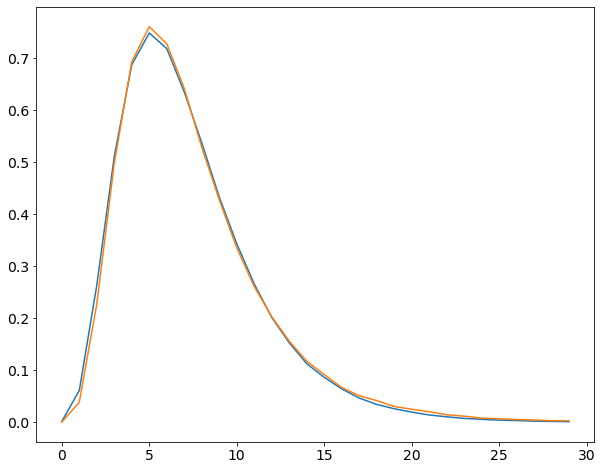

In [22]:
plt.plot(data_hist)
plt.plot(mock_hist)
plt.show()

In [17]:
def func(b, data_catalog = catalog, nbins = 60, seed = 43, los = 'x'):
    data_hist, mock_hist = density_from_bias(b, data_catalog=data_catalog, nbins=nbins, seed=seed, los=los)
    return data_hist - mock_hist

In [ ]:
opti = opt.leastsq(func=func, x0=3., full_output=1)

In [19]:
b_opt = opti[0]
b_opt

array([3.])

In [20]:
opti

(array([3.]),
 None,
 {'fvec': 0.005933881057958016,
  'nfev': 2,
  'fjac': array([[-0.]]),
  'ipvt': array([1], dtype=int32),
  'qtf': array([0.00593388])},
 'The cosine of the angle between func(x) and any column of the\n  Jacobian is at most 0.000000 in absolute value',
 4)

In [85]:
def func(b):
    data_hist, mock_hist = density_from_bias(b, data_catalog = catalog, nbins = 60, seed = 43, los = 'x')
    return np.abs(data_hist - mock_hist)

In [88]:
init_pars = {'b':3.}

m = Minuit(func, **init_pars)

t1 = time.time()
imin = m.migrad()
t2 = time.time()

print('Execution time: {:.2f}'.format(t2-t1))

RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)

In [86]:
imin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.22                      │              Nfcn = 179              │
│ EDM = 2.81e-07 (Goal: 0.0002)    │          time = 4453.9 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b         │   2.02    │   0.13    │            │            │         │         │       │
│ 1 │ a1        │    -4     │    12     │            │            │         │         │       │
│ 2 │ a2        │   -0.25   │   0.25    │            │            │         │         │       │
│ 3 │ a3        │  0.0021   │  0.0013   │            │            │         │         │       │
│ 4 │ alpha_par │   1.001   │   0.009   │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────────────────────────┐
│           │         b        a1        a2        a3 alpha_par │
├───────────┼───────────────────────────────────────────────────┤
│         b │    0.0164     -1.08    0.0143 -4.39e-05   -0.0002 │
│        a1 │     -1.08       154     -2.94    0.0129    0.0207 │
│        a2 │    0.0143     -2.94    0.0637 -0.000305 -0.000432 │
│        a3 │ -4.39e-05    0.0129 -0.000305  1.58e-06   2.1e-06 │
│ alpha_par │   -0.0002    0.0207 -0.000432   2.1e-06  8.04e-05 │
└───────────┴───────────────────────────────────────────────────┘